### Numpy-имплементация многослойной нейронной сети

**Разработчик: Артём Бабенко**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week01_intro/homework.ipynb)


В этом задании необходимо будет самостоятельно реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.

In [2]:
import numpy as np

In [3]:
# # Load dependencies
# !wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week01_intro/util.py"

## utils.py


In [7]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

# f: функция, для которой необходимо вычислить градиент.
# x: точка, в которой вычисляется градиент.
# verbose: флаг для вывода значений градиента для каждой координаты.
# h: малое значение для приближенного вычисления производной.

def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad


import os
import sys
import gzip
import numpy as np
import urllib.request

def load_mnist(flatten=False):
    """Загружает датасет MNIST с GitHub репозитория и кэширует его локально."""

    # Ссылки на файлы MNIST в репозитории GitHub
    base_url = "https://raw.githubusercontent.com/golbin/TensorFlow-MNIST/master/mnist/data/"
    filenames = {
        "train_images": "train-images-idx3-ubyte.gz",
        "train_labels": "train-labels-idx1-ubyte.gz",
        "test_images": "t10k-images-idx3-ubyte.gz",
        "test_labels": "t10k-labels-idx1-ubyte.gz"
    }

    # Функция для загрузки файла с GitHub
    def download(filename):
        url = base_url + filename
        print(f"Downloading {filename} from {url}")
        urllib.request.urlretrieve(url, filename)

    # Функции для загрузки изображений и меток
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # Загрузка тренировочных, тестовых и валидационных данных
    X_train = load_mnist_images(filenames["train_images"])
    y_train = load_mnist_labels(filenames["train_labels"])
    X_test = load_mnist_images(filenames["test_images"])
    y_test = load_mnist_labels(filenames["test_labels"])

    # Разделение тренировочного набора на обучение и валидацию
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # Векторизация при необходимости
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test



def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])


Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """

    def __init__(self, input_units=None, output_units=None, learning_rate=0.01):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        # 1. инициализируем для полносвязного слоя вектор матрицу весов (w) и вектор смещения - bias (b) по формуле: f(x) = xw + и, где x - входной вектор
        # 2. также добавим learning_rate для регилирования размера шага в торону антиградиента для корректировки весов во время обучения

        # количество входных и выходных нейронов в сети
        self.input_units = input_units
        self.output_units = output_units
        self.learning_rate = learning_rate

        if input_units and output_units:
            # learning_rate = 0.01
            self.weights = np.random.randn(input_units, output_units) * 0.01
            self.biases = np.zeros(output_units)

        # хранение активации в forward: хранения входных данных, поступающих в слой на этапе forward, используются потом в backward
        self.last_tensor = None

        pass


    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.

        self.last_input = input # сохраняет то что вернуд forward для использовния в backward


        return input


    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input) # chain rule

### Дальнейший план

В этом задании необходимо построить нейросеть для классификации рукописных цифр. Для этого понадобится реализовать следующее:
- ReLU слой
- Полносвязный слой, $f(X)=W \cdot X + b$
- Функцию потерь, для задачи классификации - cross-entropy
- Алгоритм обратного распространения ошибки

Далее вам необходимо будет реализовать каждый из пунктов выше, пользуяюсь предоставленными сниппетами кода.


### ReLU слой
В этом слое применяется поэлементная нелинейность $f(X)=max(X,0)$. В этом слое необходимо реализовать только .forward() метод.

In [5]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.maximum(0, input)  # Применяем ReLU поэлементно по формуле Relu(x) = max(0, x)
        return output

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0  # true/false. Создаем маску для градиентов, показывает, на какие элементы градиентов нужно воздействовать, а какие оставить нулевыми
        return grad_output * relu_grad_mask  # Умножаем градиенты на маску

Для отладки градиентов, вычисленных аналитически, рекомендуется использовать сравнение с градиентами, вычисленными численно, как рассказывалось на лекции. Если вы корректно реализовали методы .forward() и .backward(), то значения градиентов окажутся достаточно близкими. Функция численного подсчета градиентов уже реализована в файле util.py

In [8]:
# some tests
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Полносвязный слой

У полносвязного слоя есть обучаемые параметры: матрица линейного преобразования и столбец свободных членов.

$$f(X)= W \cdot X + b $$

* X - матрица входных данных размера [batch_size, num_features],
* W - матрица преобразования размера [num_features, num_outputs]
* b - столбец свободных членов размера [num_outputs]

W и b необходимо инициализировать во время создания слоя и обновлять при каждом вызове метода .backward().
Для этого слоя вам необходимо реализовать как прямой, так и обратный проход. Формулы для аналитического подсчета градиентов можно взять из лекции, но рекомендуется проверить их самостоятельно на бумаге.

In [9]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):  # задали в Layer классе
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W * x> + b
        """
        super().__init__(input_units, output_units, learning_rate)


    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W * x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        self.last_input = input
        return np.dot(input, self.weights) + self.biases


    def backward(self, input, grad_output):
        """
        Compute the gradients and update the parameters.

        input shape: [batch, input_units]
        grad_output shape: [batch, output_units]
        """
        # Градиент по входу: dL/dX = dL/dY * dY/dX = grad_output * W.T
        grad_input = np.dot(grad_output, self.weights.T)

        # Градиенты по весам и смещениям
        grad_weights = np.dot(input.T, grad_output)  # dL/dW = X.T * grad_output
        grad_biases = np.sum(grad_output, axis=0)    # dL/db = sum(grad_output)

        # Проверка формы градиентов
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        # Обновление параметров (шаг градиентного спуска)
        self.weights -= self.learning_rate * grad_weights
        self.biases -= self.learning_rate * grad_biases

        return grad_input

### Тестирование полносвязного слоя

Три следующих блока тестируют вашу реализацию, если все корректно, вы трижды получите "Well done!"

In [10]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [13]:
# To test the grads, we use gradients obtained via finite differences

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [14]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)

def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases

w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### Функция потерь

Вычисление функции потерь для задачи классификации, а также ее градиента уже сделано для вас.

In [15]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [16]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Итоговая нейросеть

Все готово для запуска нейросети. Нейросеть будем тестировать на классическом датасете MNIST. Код ниже визуализирует несколько примеров из этого датасета.

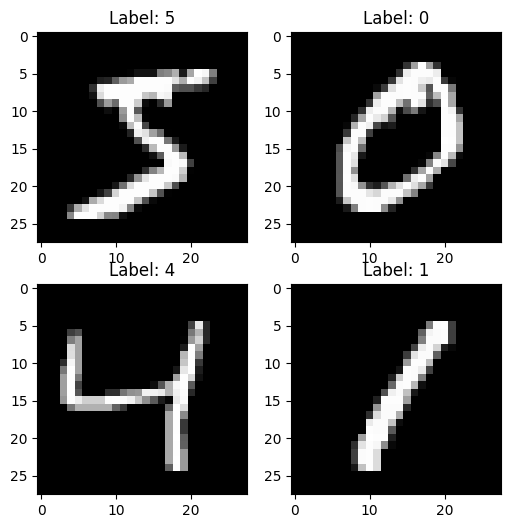

In [18]:
import matplotlib.pyplot as plt


# Загрузка MNIST напрямую с гитхаба
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)


plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray')

plt.show()


В нашей реализации сеть - просто список (Python-list) слоев.

In [19]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

Реализуйте прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [20]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # forward
    for layer in network:
        input = layer.forward(input)
        activations.append(input)

    assert len(activations) == len(network)
    return activations

In [21]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Получение активаций слоев
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Вычисление потерь и начального градиента
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

    # Backward
    grad_output = loss_grad
    for i in reversed(range(len(network))):
        layer = network[i]
        grad_output = layer.backward(layer_inputs[i], grad_output)  # Обновляем grad_output для предыдущего слоя

    return np.mean(loss)


Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%.

In [22]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [23]:
from IPython.display import clear_output
train_log = []
val_log = []

In [24]:
def predict(network, X):
    logits = forward(network, X)[-1]  # Прогон через всю сеть и получение логитов
    return logits.argmax(axis=-1)     # Выбор индекса с максимальным значением логита для каждого образца


Epoch 14
Train accuracy: 0.9912
Val accuracy: 0.9713


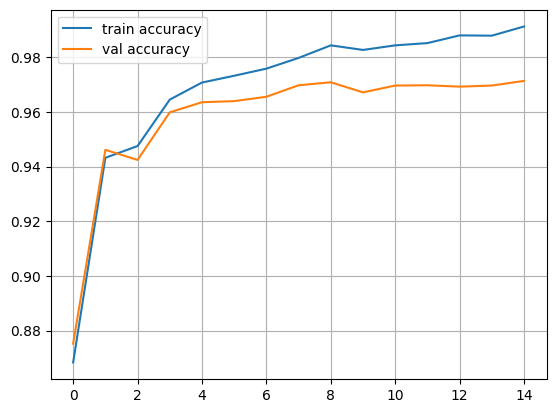

In [25]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


## Нейросеть для извлечения представлений
Помимо собственно классификации, нейросети часто используют для получения векторных описаний (embeddings) объектов различной природы. Часто в качестве представлений можно взять просто векторы активаций нейронов с одного из последних слоев. Вычислим такие представления:

In [26]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

Полученные представления можно использовать в любых целях, в комбинации с другими инструментами машинного обучения.
Сравним обученные представления для изображений из MNIST c исходными 784-мерными представлениями. Постройте t-SNE визуализации 1000 случайных изображений из X_train, полученные на основе исходных 784-мерных представлений и обученных представлений. Сделайте вывод о качестве представлений.

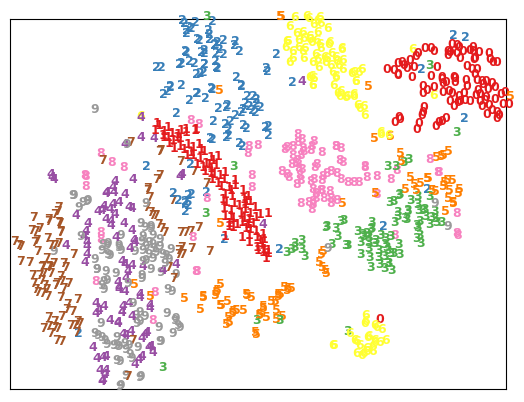

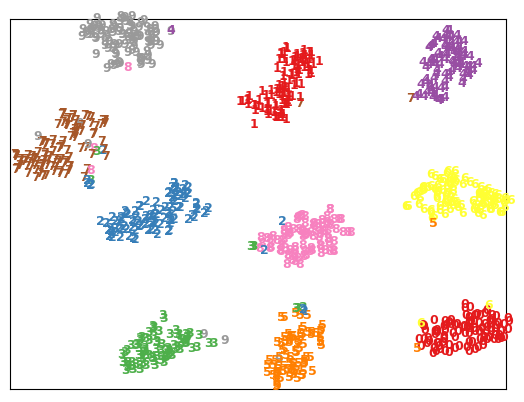

In [28]:
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]

X_subset = X_train[subset_ids]
y_subset = y_train[subset_ids]

# t-SNE для исходных 784-мерных представлений, снижает эту размерность
x_original_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_subset)

# Получение обученных представлений
x_learnt = forward(network, X_subset)[-1]

# t-SNE для обученных представлений
x_learnt_tsne = TSNE(n_components=2, random_state=42).fit_transform(x_learnt)

plot_embedding(x_original_tsne, y_subset)
plot_embedding(x_learnt_tsne, y_subset)


Наконец, исследуем универсальность полученных представлений. Используем их для решения другой задачи классификации: предсказание четности изображенной цифры.

In [29]:
new_y_train = y_train % 2
new_y_test = y_test % 2

Обучите простейшую логистическую регресиию, предсказывающую четность изображенной цифры, используя в качестве вектора признаков:

1) исходные 784-мерные представления

2) обученные представления

Сравните качество и сделайте вывод об универсальности обученных представлений.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Логистическая регрессия на исходных 784-мерных представлениях
lr_original = LogisticRegression(solver="lbfgs", max_iter=1000)
lr_original.fit(X_train, new_y_train)
original_preds = lr_original.predict(X_test)
original_accuracy = accuracy_score(new_y_test, original_preds)
print(f"Accuracy on original 784-dimensional features: {original_accuracy:.4f}")

# 2. Логистическая регрессия на обученных представлениях
# Получение обученных представлений на тренировочных и тестовых данных
train_learned = forward(network, X_train)[-1]
test_learned = forward(network, X_test)[-1]

lr_learned = LogisticRegression(solver="lbfgs", max_iter=1000)
lr_learned.fit(train_learned, new_y_train)
learned_preds = lr_learned.predict(test_learned)
learned_accuracy = accuracy_score(new_y_test, learned_preds)
print(f"Accuracy on learned representations: {learned_accuracy:.4f}")


Accuracy on original 784-dimensional features: 0.9022
Accuracy on learned representations: 0.9534
